[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ourownstory/neural_prophet/blob/master/tutorials/feature-use/events_holidays_peyton_manning.ipynb)

# Modeling Holidays and Special Events

If you have holidays or other recurring events that you’d like to model, you must create a dataframe for them. It has two columns (`event` and `ds`) and a row for each occurrence of the holiday. It must include all occurrences of the holiday, both in the past (back as far as the historical data go) and in the future (out as far as the forecast is being made). If they won’t repeat in the future, Prophet will model them and then not include them in the forecast.

Events can be added as either additive or multiplicative components.

Windows can additionally be defined to include days before/after the event.

We will use the time series of the log daily page views for the Wikipedia page for Peyton Manning as an example.
First, we load the data:

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes

import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
set_log_level("ERROR")

In [2]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
df = pd.read_csv(data_location + "wp_log_peyton_manning.csv")

Here we create a dataframe that includes the dates of all of Peyton Manning’s playoff appearances, including past events and future events:

In [3]:
## user specified events
# history events
playoffs = pd.DataFrame({
    'event': 'playoff',
    'ds': pd.to_datetime([
        '2008-01-13', '2009-01-03', '2010-01-16',
        '2010-01-24', '2010-02-07', '2011-01-08',
        '2013-01-12', '2014-01-12', '2014-01-19',
        '2014-02-02', '2015-01-11', '2016-01-17',
        '2016-01-24', '2016-02-07',
    ]),
})

superbowls = pd.DataFrame({
    'event': 'superbowl',
    'ds': pd.to_datetime([
        '2010-02-07', '2012-02-05', '2014-02-02', 
        '2016-02-07',
    ]),
})

events_df = pd.concat((playoffs, superbowls))

##  Additive Events

Once the table is created, event effects are included in the model by adding them in with the `add_events` function.

By default, events are modelled as additive events. Here, we model both playoffs as additive events.

Additionally we change the `loss_func` to 'MSE', as the events we are fitting weights fore are a few rare outliers. 
Usually we would not want to skew our model with a few outliers, thus the default loss function is 'Huber'.

In [4]:
# NeuralProphet Object
m = NeuralProphet(loss_func="MSE")

# set the model to expect these events
m = m.add_events(["playoff", "superbowl"])

# create the data df with events
history_df = m.create_df_with_events(df, events_df)

In [5]:
# fit the model
metrics = m.fit(history_df, freq="D")

  0%|          | 0/273 [00:00<?, ?it/s]

In [6]:
# forecast with events known ahead
future = m.make_future_dataframe(df=history_df, events_df=events_df, periods=365, n_historic_predictions=len(df))
forecast = m.predict(df=future)

The events effect can be seen in the forecast dataframe:

In [7]:
events = forecast[(forecast['event_playoff'].abs() + forecast['event_superbowl'].abs()) > 0]
events.tail()

,ds,y,yhat1,residual1,trend,season_yearly,season_weekly,events_additive,event_playoff,event_superbowl
2190,2014-02-02,11.760520,11.739920,-0.020600,8.361824,0.776849,0.03111,2.570135,1.047041,1.523094
2532,2015-01-11,9.886596,9.889818,0.003223,7.923612,0.888056,0.03111,1.047041,1.047041,0.000000
2901,2016-01-17,9.273878,9.659006,0.385128,7.593356,0.987498,0.03111,1.047041,1.047041,0.000000
2908,2016-01-24,NaN,9.660078,NaN,7.587125,0.994801,0.03111,1.047041,1.047041,0.000000
2922,2016-02-07,NaN,10.775986,NaN,7.574663,0.600078,0.03111,2.570135,1.047041,1.523094


The events effects will also show up in the plots, where we see that there is a spike on the days around playoff appearances, with an especially large spike for the superbowl:

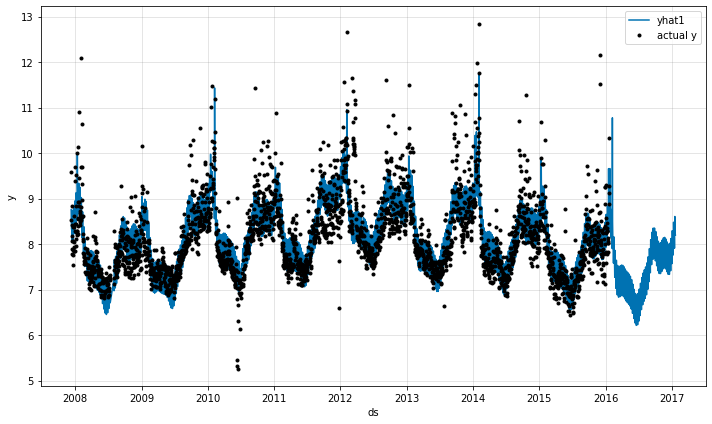

In [8]:
## plotting forecasts
fig = m.plot(forecast)

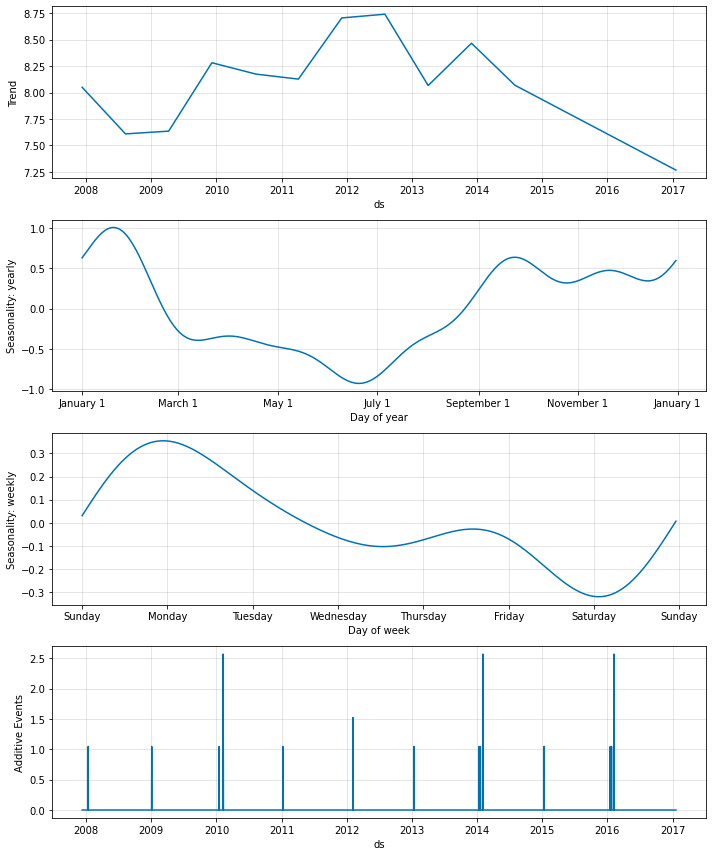

In [9]:
## plotting components
fig_comp = m.plot_components(forecast)

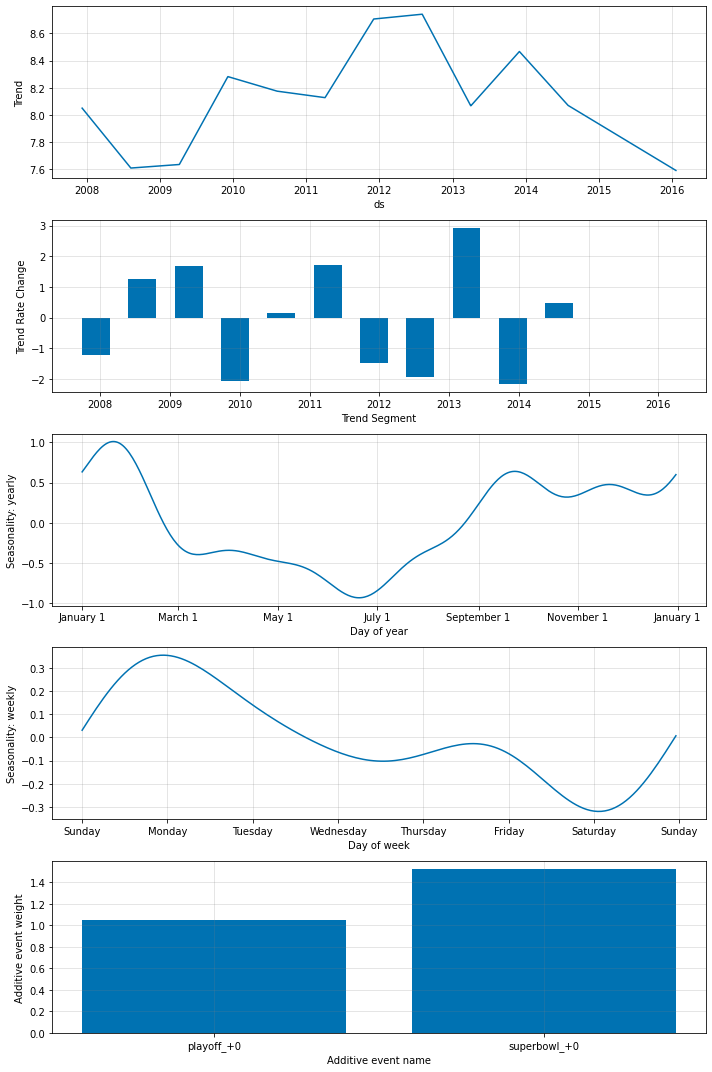

In [10]:
## plotting parameters
fig_param = m.plot_parameters()

## Event Windows
You can also include the arguments `lower_window` and `upper_window` which extend the holiday out to `[lower_window, upper_window]` days around the date. 

For instance, if you wanted to include Christmas Eve in addition to Christmas you’d include `lower_window=-1, upper_window=0`. If you wanted to use Black Friday in addition to Thanksgiving, you’d include `lower_window=0, upper_window=1`. 

In [11]:
m = NeuralProphet(loss_func="MSE")

# set event configs to NeuralProphet object with windows
m = m.add_events(["playoff"], upper_window=1)
m = m.add_events(["superbowl"], lower_window=-1, upper_window=1)

# create the data df with events
history_df = m.create_df_with_events(df, events_df)

# fit the model
metrics = m.fit(history_df, freq="D")

  0%|          | 0/273 [00:00<?, ?it/s]

In [13]:
forecast = m.predict(history_df)

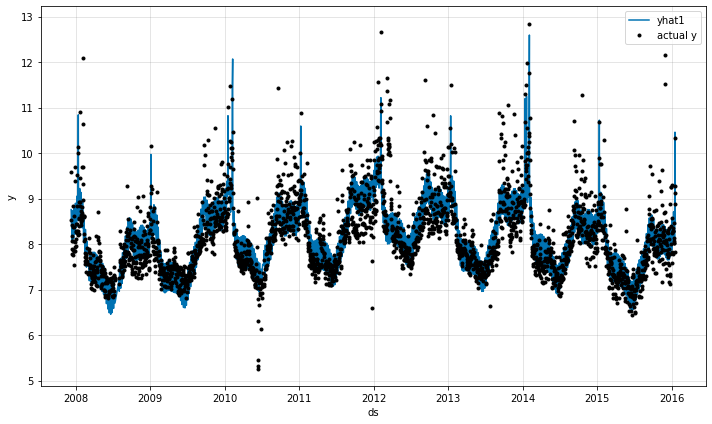

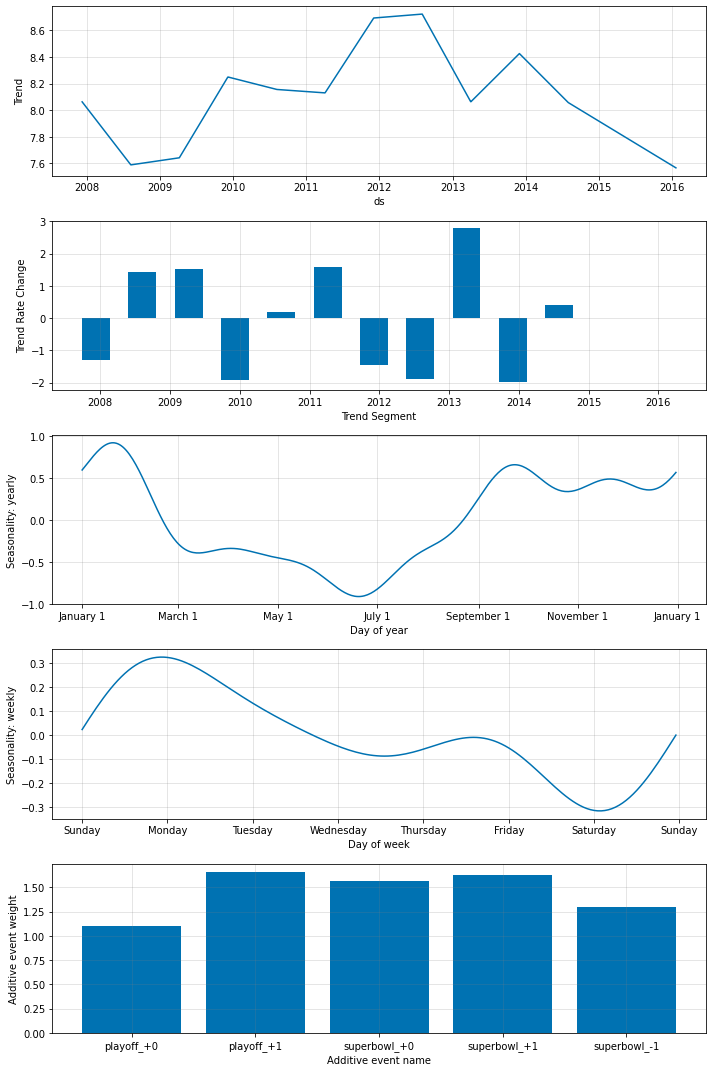

In [14]:
## plotting parameters
fig = m.plot(forecast)
fig_param = m.plot_parameters()

## Multiplicative Events

In [15]:
m = NeuralProphet(loss_func="MSE")

# set event configs to NeuralProphet object with windows
m = m.add_events(["playoff"], upper_window=1)
m = m.add_events(["superbowl"], lower_window=-1, upper_window=1, mode="multiplicative")

# create the data df with events
history_df = m.create_df_with_events(df, events_df)

# fit the model
metrics = m.fit(history_df, freq="D")

  0%|          | 0/273 [00:00<?, ?it/s]

In [16]:
forecast = m.predict(history_df)

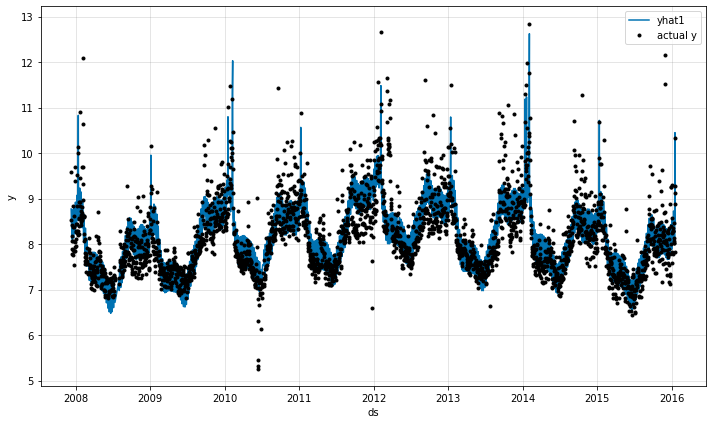

In [17]:
## plotting components
fig_comp = m.plot(forecast)

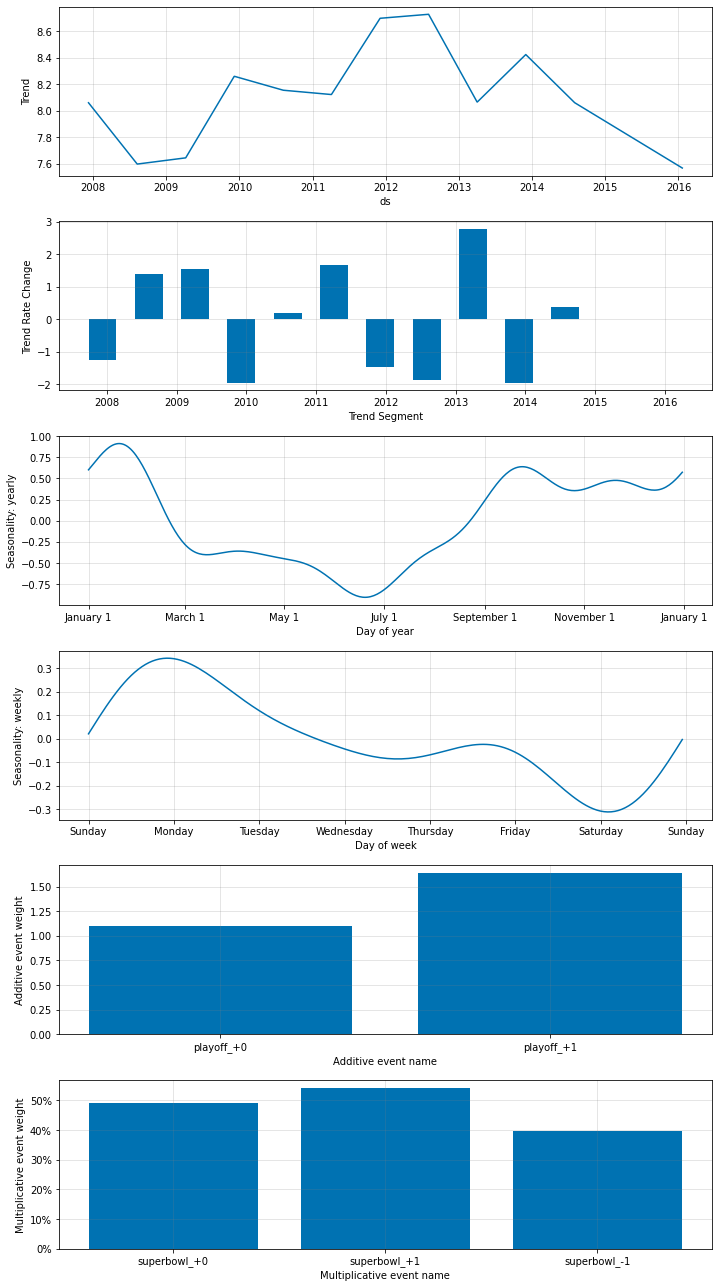

In [18]:
# plot parameters
fig_param = m.plot_parameters()

## Country Specific Holidays

In [19]:
m = NeuralProphet()

# add the country specific holidays
m = m.add_country_holidays("US")

# fit the model
metrics = m.fit(df, freq="D")

  0%|          | 0/273 [00:00<?, ?it/s]

In [20]:
forecast = m.predict(df)

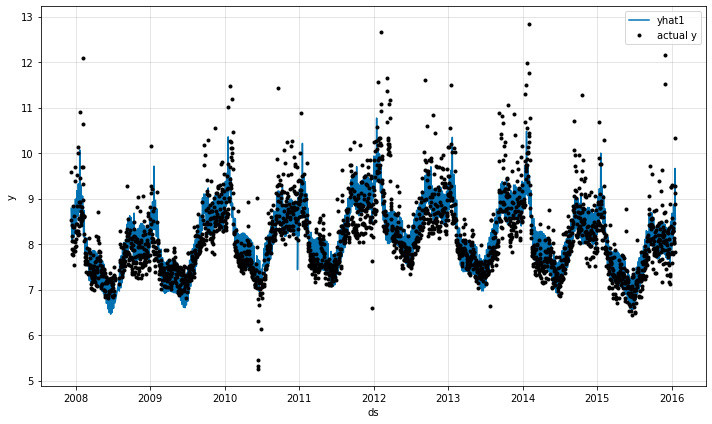

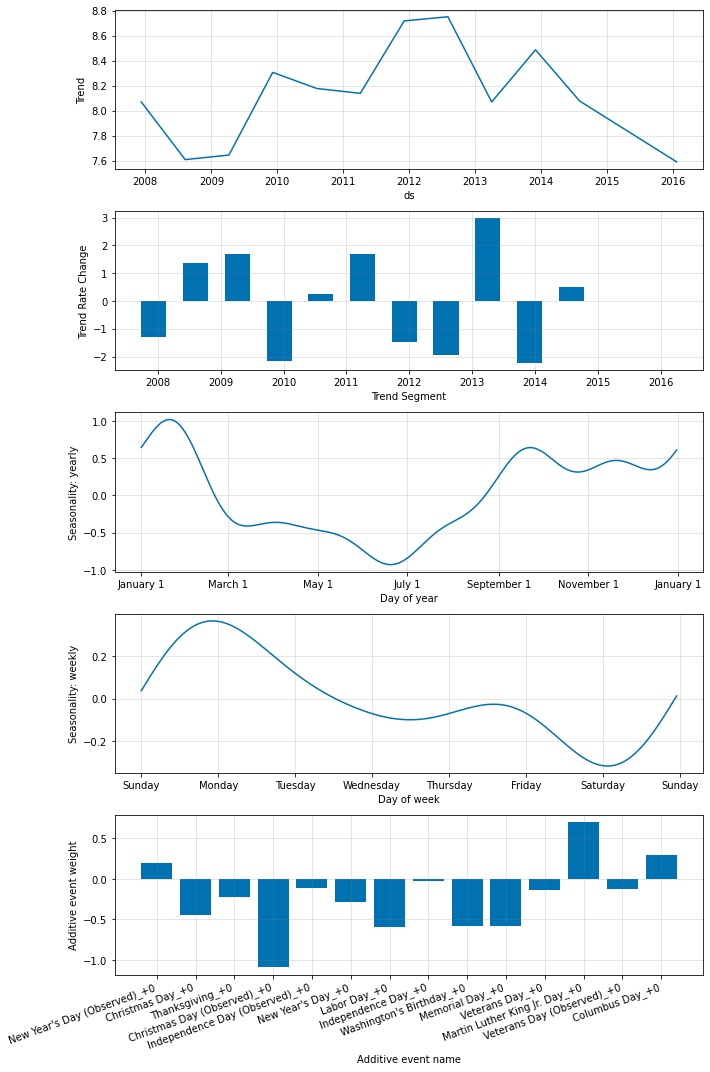

In [21]:
## plotting components
fig = m.plot(forecast)
fig_param = m.plot_parameters()